### 1. Загрузка и первичный смотр датасета

In [1]:
# Подключение пакетов (библиотек)  
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Чтение данных 
data = pd.read_csv('listingss.csv')

# Размерность данных
print(data.shape)
# Вывод таблица данных
pd.set_option('display.max_columns', None)
data.head()

(69351, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,106332,"Lovely large room, Bethnal Green",264345,Susie,NaN,Tower Hamlets,51.52874,-0.05396,Private room,55,3,65,2016-06-10,0.47,1,74,0,NaN
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,50,1,30,2022-07-15,0.20,2,343,9,NaN
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,1481412,Luca,NaN,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,42,2022-01-04,0.34,1,222,1,NaN
3,107048,A Luxury Studio Suite in Clerkenwell,259088,Simon,NaN,Islington,51.52478,-0.10484,Private room,180,4,493,2022-09-02,3.59,5,236,20,NaN
4,284603,Notting Hill church stay in Heaven!,1481851,Tania,NaN,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,6,2022-07-04,0.05,1,180,2,NaN


Имеем 69351 объект (экземпляр). Каждый объект имеет 18 признаков, один из которых является целевым (требуется предсказывать).

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              69351 non-null  int64  
 1   name                            69330 non-null  object 
 2   host_id                         69351 non-null  int64  
 3   host_name                       69346 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   69351 non-null  object 
 6   latitude                        69351 non-null  float64
 7   longitude                       69351 non-null  float64
 8   room_type                       69351 non-null  object 
 9   price                           69351 non-null  int64  
 10  minimum_nights                  69351 non-null  int64  
 11  number_of_reviews               69351 non-null  int64  
 12  last_review                     

In [3]:
data.size

1248318

#### Выберем признак для задачи классификации

##### Признак "neighbourhood" или "район Лондона (боро)"
Всего в лондоне 32 боро и Лондонский Сити, а значит размер массива уникальных значений столбца "neighbourhood" должно быть 33

In [4]:
data['neighbourhood'].unique()
len(data['neighbourhood'].unique())

33

Так как есть наличие таких признаков как latitude и longitude, то классифицировать данные по признаку neighbourhood является бессмысленным. Но если убрать приведенные два признака, то появляется задача предсказания возможного района расположения хоста. В принципе, даже если оставить координаты, то без знания точных границ районов, а этого знания у нас нет, невозможно доставерно установить имя района хоста, но тогда задача не имеет смысла.

##### Признак "room_type" или тип комнаты/жилого помещения

In [5]:
data['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

Задача может состоять в предсказании типа жилого помещения, которое будет наиболее соот-ть данным объявления.

##### Признаки "number_of_reviews" и "number_of_reviews" 

Такие признаки изначально принадлежат более задаче регрессии, но можно переформулировать задачу и задать интервалы, к которому будут относится входные данные. Например, рассмотрим признак "number_of_reviews":

<AxesSubplot: >

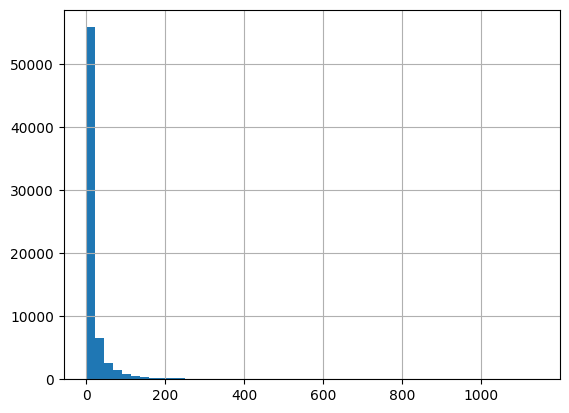

In [6]:
# pd
data['number_of_reviews'].hist(bins=50)
# тоже самое на seaborn
# sns.histplot(data = data, x='number_of_reviews', bins = 50)

<AxesSubplot: >

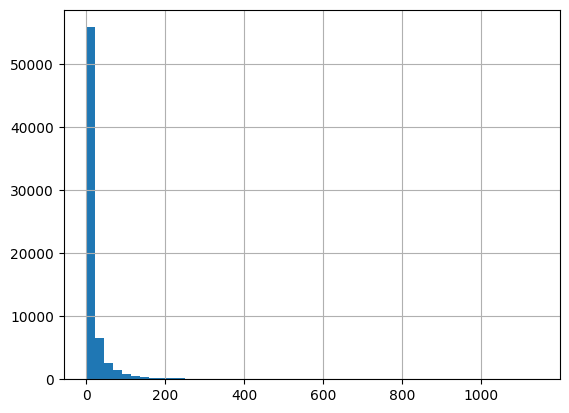

In [7]:
data.loc[data['number_of_reviews'] < 1800, 'number_of_reviews'].hist(bins = 50)

<AxesSubplot: ylabel='Density'>

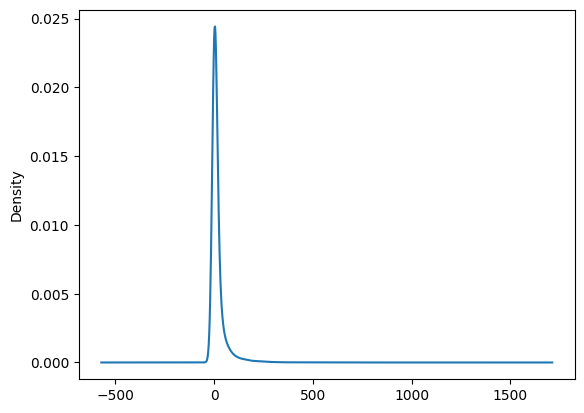

In [8]:
# Функция плотности распределения
data.loc[data['number_of_reviews'] < 1800, 'number_of_reviews'].plot.kde(bw_method=0.3)

<AxesSubplot: ylabel='Density'>

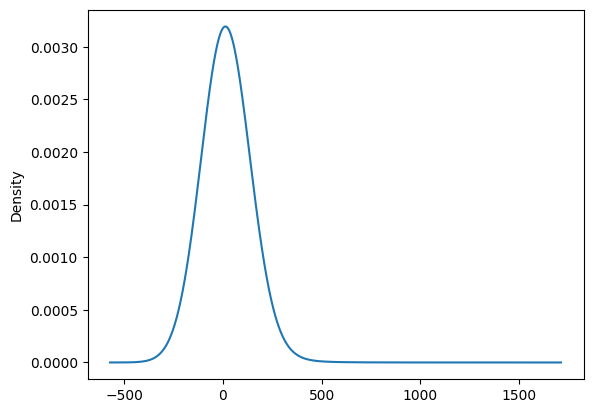

In [9]:
data.loc[data['number_of_reviews'] < 1800, 'number_of_reviews'].plot.kde(bw_method=3)

<AxesSubplot: ylabel='Density'>

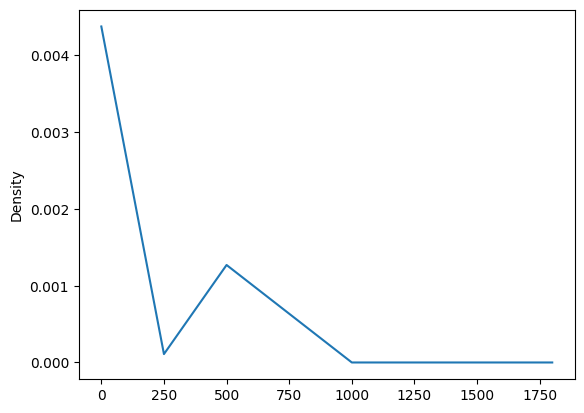

In [10]:
data.loc[data['number_of_reviews'], 'number_of_reviews'].plot.kde(ind=[0, 250, 500, 1000, 1800])

<AxesSubplot: xlabel='number_of_reviews', ylabel='Density'>

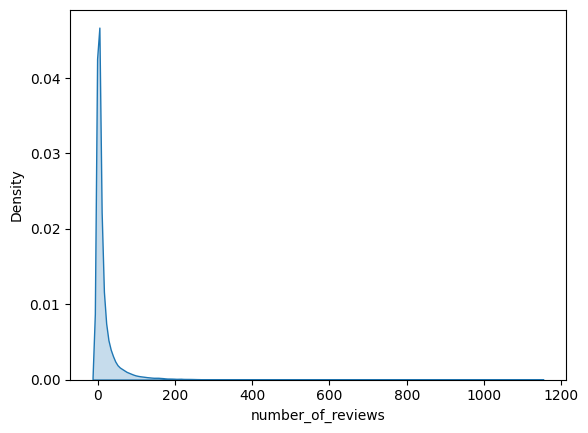

In [11]:
sns.kdeplot(data['number_of_reviews'], fill=True)


<AxesSubplot: xlabel='number_of_reviews', ylabel='Density'>

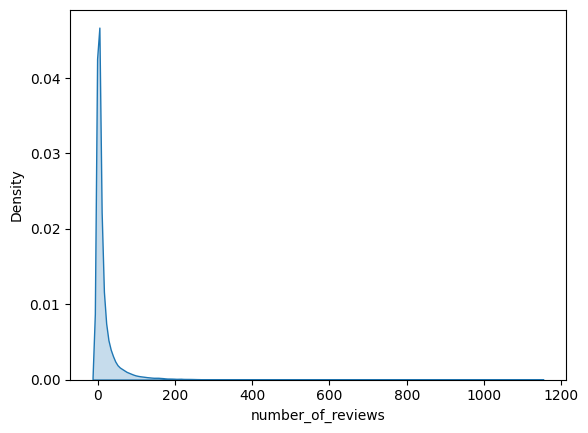

In [12]:
sns.kdeplot(data.loc[data['number_of_reviews'] < 1800, 'number_of_reviews'], fill=True)

Из построенных гистограмм видно, что можно разделить стоимость ежедневной аренды на интервалы, например: 0, (0, 250], (250, 500], (500, 1000], (1000, 1800], (1800, +inf)

<AxesSubplot: xlabel='number_of_reviews', ylabel='Count'>

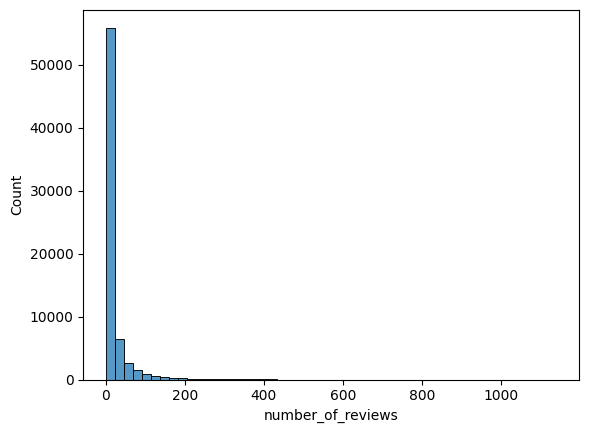

In [13]:
# Признак "number_of_reviews"
sns.histplot(data = data, x='number_of_reviews', bins = 50)

##### Признак "minimum_nights" - минимальное количество ночей

In [14]:
data['minimum_nights'].unique()

array([   3,    1,    5,    4,   14,    2,    7,   10,   30,   15,    6,
         21,   28,   13,  150,   40,   20,   45,    8,   90,  180,   12,
        270,  300,   60,  186,   91,   25,   75,   29,   24,   11,   18,
        100,   50,  365,   19,  360,  183,  160,  153,   16,   58,  120,
          9,   26,   55,   35,   84,   42,  187,   23,   17,   56,  999,
        200,   80,  185,   31,   89, 1000,  163,  600,   49,   70,  260,
        500,  170, 1124,  400,   27,   78,  175,   22,   99,   94,   87,
        280,  115,   33,  350,   73,  140,   44,  182,   62,  900,  112,
         88,   59,   79,   76,   86,   69,  330,   64,  250,   63, 1125,
        110,  101,   92,   32,  130,  255,  258,   53,  135,   85,   71,
        121,   61,  190,   81,   54,  155,   41,  181,   83,   43,   51,
         38,   98,   93], dtype=int64)

По значениям этого признака можно представить, например, интервалы: около недели, около 1 месяца, ..., около полугода, ..., около года, ..., больше года, ...

In [15]:
# Посмотрим, какие экземпляры соответствуют атрибуту "minimal_nights" со значением "1124"
data[data['minimum_nights'] == 1124]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
6839,7974622,Amazing Victoria era flat,42087931,O,NaN,Tower Hamlets,51.53216,-0.06177,Entire home/apt,5000,1124,22,2018-08-26,0.27,1,83,0,NaN
17637,18502500,Awesome penthouse flat in the heart of Dalston,11024666,Pete,NaN,Hackney,51.54703,-0.07512,Private room,63,1124,37,2019-09-09,0.60,2,0,0,NaN
24033,22965536,Period Victorian house with garden,45230234,Matthew,NaN,Haringey,51.57254,-0.10537,Private room,8000,1124,7,2019-08-28,0.12,1,0,0,NaN


In [16]:
data[data['minimum_nights'] == 1000]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
4198,5489381,Modern Spacious Apartment (5mins to tube),19581025,Simon,NaN,Barnet,51.59046,-0.24722,Entire home/apt,65,1000,49,2019-08-24,0.59,9,365,0,NaN
8606,9728409,Spectacular Loft Studio (5mins to tube),19581025,Simon,NaN,Barnet,51.59051,-0.24784,Entire home/apt,71,1000,94,2019-08-10,1.15,9,365,0,NaN
10403,11913450,8 MIN TO CENTRAL LONDON CTRL GREENWICH DOUBLE ...,18380191,David,NaN,Greenwich,51.47767,-0.01113,Private room,27,1000,169,2020-02-22,2.15,2,0,0,NaN
12396,13678376,Spacious double Room with PARKING!,65052637,Timur,NaN,Brent,51.55162,-0.22961,Private room,300,1000,12,2017-08-26,0.16,1,364,0,NaN
12882,13922207,"Central London, Self-contained Studio, with Ga...",82651607,John,NaN,Islington,51.53638,-0.09020,Entire home/apt,150,1000,50,2019-07-14,0.67,1,90,0,NaN
24560,23364016,8MIN LONDON BRIDGE CENTRAL LONDON CTRL GREENWICH,18380191,David,NaN,Greenwich,51.47819,-0.01125,Entire home/apt,95,1000,4,2020-01-01,0.08,2,0,0,NaN
43921,43920343,Penthouse-style loft apartment for single/couple,351641704,Ben,NaN,Brent,51.53553,-0.22522,Private room,80,1000,0,NaN,NaN,1,180,0,NaN


In [17]:
data.loc[(data['host_name'] == 'Simon') & (data['calculated_host_listings_count'] == 5)]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
3,107048,A Luxury Studio Suite in Clerkenwell,259088,Simon,NaN,Islington,51.52478,-0.104840,Private room,180,4,493,2022-09-02,3.59,5,236,20,NaN
59,304918,Luxury Studio in Clerkenwell,259088,Simon,NaN,Islington,51.52264,-0.103230,Private room,180,4,349,2022-08-30,2.75,5,249,13,NaN
159,231854,Self Contained Stylish Loft Studio in Clerkenwell,259088,Simon,NaN,Islington,51.52153,-0.100400,Private room,147,4,419,2022-08-30,3.18,5,233,37,NaN
12212,13616561,Top Floor Luxury Loft Suite in Clerkenwell,259088,Simon,NaN,Islington,51.52254,-0.102030,Entire home/apt,150,4,68,2022-08-27,0.97,5,236,4,NaN
62558,663805484653712636,Lovely 1-bedroom duplex flat in Mayfair London,259088,Simon,NaN,Westminster,51.50525,-0.147214,Entire home/apt,300,1,4,2022-08-25,2.73,5,0,4,NaN


Атрибут "room_type" будет целевым признаком

In [18]:
# Поместим атрибут "room_type" в конец датафрейма
Y = data['room_type']
data = data.drop('room_type', axis=1)
print(len(data.columns))
# Y.head()
# Y.shape

17


In [19]:
data.insert(len(data.columns)-1, 'room_type', Y)

In [20]:
print(data.shape)
print(data.index)
data.head()

(69351, 18)
RangeIndex(start=0, stop=69351, step=1)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,room_type,license
0,106332,"Lovely large room, Bethnal Green",264345,Susie,NaN,Tower Hamlets,51.52874,-0.05396,55,3,65,2016-06-10,0.47,1,74,0,Private room,NaN
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,50,1,30,2022-07-15,0.20,2,343,9,Private room,NaN
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,1481412,Luca,NaN,Tower Hamlets,51.52851,-0.07426,90,5,42,2022-01-04,0.34,1,222,1,Entire home/apt,NaN
3,107048,A Luxury Studio Suite in Clerkenwell,259088,Simon,NaN,Islington,51.52478,-0.10484,180,4,493,2022-09-02,3.59,5,236,20,Private room,NaN
4,284603,Notting Hill church stay in Heaven!,1481851,Tania,NaN,Kensington and Chelsea,51.51464,-0.20004,297,14,6,2022-07-04,0.05,1,180,2,Entire home/apt,NaN


Таким образом имеет 15 признаков для каждого экземпляра и 1 целевой признак. Установим соотношение классов.

In [21]:
values, counts = np.unique(Y, return_counts = True)
print(values, counts)

['Entire home/apt' 'Hotel room' 'Private room' 'Shared room'] [41224   244 27479   404]


### 2.1 Визуализация и описательная статистика 

Получим сводную информацию о данных с помощью функции describe:  
- count - количество элементов в столбце
- mean - среднее значение элементов
- std - стандартное отклонение значения
- min - минимальное значение
- 25% - нижний квартиль (25% значений меньше нижнего квартиля и 75% значений больше нижнего квартиля)
- 50% - медиана (50% значений меньше (ниже, левее) медианы и 50% больше (выше, правее) медианы)
- 75% - верхний квартиль (75% значений меньше верхнего квартиля и 25% значений больше верхнего квартиля)
- max - максимальное значениe
* freq - количество самого частого объекта (object)

In [22]:
#data.describe()

In [23]:
#data.describe(include='object')

In [24]:
#data[data['host_name'] == 'Alex']

На матрице диаграмм рассеивания наблюдается зависимость между числом отзывов ('number_of_reviews') и количеством отзывов в месяц ('reviews_per_month'), а также с этими двумя признаками коррелирует признак 'number_of_reviews_ltr'.

In [25]:
#data.corr()

In [26]:
#sns.heatmap(data.corr(), square=True, cmap='coolwarm')
#pass

In [27]:
#data.corr() > 0.5

In [28]:
#data.corr().where(np.triu(data.corr() > 0.5, k=1)).stack().sort_values(ascending=False)

In [29]:
#sns.histplot(data['number_of_reviews'], bins=15)
#plt.grid()
#pass

In [30]:
#sns.jointplot(data=data, x='number_of_reviews', y='reviews_per_month',kind="reg", marginal_kws=dict(bins=25, fill=True)) # alpha=0.5
#sns.jointplot(data=data, x='number_of_reviews', y='reviews_per_month', alpha=0.05) 

Ящик с усами

In [31]:
#sns.boxplot(data=data, x='room_type', y="price")
#pass

In [32]:
#sns.boxplot(data=data, x='room_type', y="number_of_reviews")
#pass

In [33]:
# sns.boxplot(data=data, x='room_type', y="availability_365")
# pass

In [34]:
# plt.plot(data['reviews_per_month'], data['availability_365'], 'o', alpha = 0.05)
# plt.xlabel('reviews_per_month')
# plt.ylabel('availability_365')
# plt.title('reviews_per_month vs availability_365')
# pass

In [35]:
# plt.plot(data['number_of_reviews_ltm'], data['number_of_reviews'], 'o', alpha = 0.05)
# plt.xlabel('number_of_reviews_ltm')
# plt.ylabel('number_of_reviews')
# plt.title('number_of_reviews_ltm vs number_of_reviews')
# pass

In [36]:
# plt.plot(data['host_id'], data['number_of_reviews'], 'o', alpha = 0.05)
# plt.xlabel('host_id')
# plt.ylabel('number_of_reviews')
# plt.title('host_id vs number_of_reviews')
# pass

In [37]:
# plt.figure(figsize = (10, 6))

# colors = ['b', 'r', 'g', 'y']

# for i in range(0, len(data['room_type'].unique())):
#   plt.scatter(data[data['room_type'] == data['room_type'].unique()[i]]['availability_365'],
#               data[data['room_type'] == data['room_type'].unique()[i]]['price'],
#               alpha = 0.15,
#               label = data['room_type'].unique()[i],
#               color = colors[i])

# plt.xlabel('availability_365')
# #plt.xticks(range(365))
# #plt.xlim(0, 365)
# plt.ylabel('price')
# plt.legend()
# plt.grid()

In [38]:
# plt.figure(figsize = (10, 6))

# colors = ['b', 'r', 'g', 'y']

# for i in range(0, len(data['room_type'].unique())):
#   plt.scatter(data[data['room_type'] == data['room_type'].unique()[i]]['price'],
#               data[data['room_type'] == data['room_type'].unique()[i]]['availability_365'],
#               alpha = 0.15,
#               label = data['room_type'].unique()[i],
#               color = colors[i])

# plt.xlabel('price')
# plt.xticks(np.arange(0, 1800, step=200))
# plt.xlim(0, 1800)
# plt.ylabel('availability_365')
# plt.legend()
# plt.grid()

In [39]:
# plt.figure(figsize = (10, 6))

# colors = ['w', 'w', 'w', 'y']

# for i in range(0, len(data['room_type'].unique())):
#   plt.scatter(data[data['room_type'] == data['room_type'].unique()[i]]['host_id'],
#               data[data['room_type'] == data['room_type'].unique()[i]]['number_of_reviews'],
#               alpha = 0.15,
#               label = data['room_type'].unique()[i],
#               color = colors[i])

# plt.xlabel('host_id')
# plt.xlim(0)
# plt.ylabel('number_of_reviews')
# plt.yticks(np.arange(0, 255, 50))
# plt.ylim(0, 255)
# plt.legend()
# plt.grid()

In [40]:
# plt.figure(figsize = (10, 6))

# colors = ['b', 'w', 'w', 'w']

# for i in range(0, len(data['room_type'].unique())):
#   plt.scatter(data[data['room_type'] == data['room_type'].unique()[i]]['host_id'],
#               data[data['room_type'] == data['room_type'].unique()[i]]['number_of_reviews'],
#               alpha = 0.15,
#               label = data['room_type'].unique()[i],
#               color = colors[i])

# plt.xlabel('host_id')
# plt.xlim(0)
# plt.ylabel('number_of_reviews')
# plt.yticks(np.arange(0, 255, 50))
# plt.ylim(0, 255)
# plt.legend()
# plt.grid()

In [41]:
# plt.figure(figsize = (10, 6))

# colors = ['w', 'r', 'w', 'w']

# for i in range(0, len(data['room_type'].unique())):
#   plt.scatter(data[data['room_type'] == data['room_type'].unique()[i]]['host_id'],
#               data[data['room_type'] == data['room_type'].unique()[i]]['number_of_reviews'],
#               alpha = 0.15,
#               label = data['room_type'].unique()[i],
#               color = colors[i])

# plt.xlabel('host_id')
# plt.xlim(0)
# plt.ylabel('number_of_reviews')
# plt.yticks(np.arange(0, 255, 50))
# plt.ylim(0, 255)
# plt.legend()
# plt.grid()

In [42]:
# plt.figure(figsize = (10, 6))

# colors = ['w', 'w', 'g', 'w']

# for i in range(0, len(data['room_type'].unique())):
#   plt.scatter(data[data['room_type'] == data['room_type'].unique()[i]]['host_id'],
#               data[data['room_type'] == data['room_type'].unique()[i]]['number_of_reviews'],
#               alpha = 0.15,
#               label = data['room_type'].unique()[i],
#               color = colors[i])

# plt.xlabel('host_id')
# plt.xlim(0)
# plt.ylabel('number_of_reviews')
# plt.yticks(np.arange(0, 255, 50))
# plt.ylim(0, 255)
# plt.legend()
# plt.grid()

Между количеством отзывов и идентификатором хоста нет зависимости, но можно увидеть, что значения "общей комнаты" ("shared room") и комнаты в отеле ("hotel room") являются редкими и зачастую ими занимаются одни и теже хосты. Связь в постоянстве класса сдаваемых хостами жилых помещений очевидна и для оставшихся двух признаках, но там это менее заметно, в силу большой распространенности услуг по сдаче отдельных комнат и целых домов (синие и красные). Синие точки больше отрываются от оси абцисс (host_id), так как отзывов на дешевые и многочисленные по количеству объявлений отдельные комнаты больше. В тоже время для ещё более многочисленного класса "весь дом/квартира" ("entire home/apt") - красные точки - заметно приближение к оси абции и кучкование там, т.е. отзывов меньше, что разумно в силу дороговизны таких аренд. Тем не менее для синих и красных точек существуют и объявления с большим числом отзывов.

### 3. Пропущенные значения

#### 1-й способ

In [43]:
# Массив индексов и столбцов, где значение равно NaN
indexNan, columnNan = np.where(pd.isnull(data))
# Выделим значения столбцов и подсчитаем, сколько раз в каждом столбце встречается значение NaN
values, counts = np.unique(columnNan, return_counts = True)
print(values)
print(counts)
print(counts.sum())

[ 1  3  4 11 12 17]
[   21     5 69351 16780 16780 69351]
172288


Таким образом мы имеем 172288 пропущенных значений (ячейки со значением NaN) из 1206540 ячеек.

In [44]:
# Процентное соотношение
# 1206540 18 признаков
print(172288/(1206540/100))
# 1178967 17 признаков без целевого
print(172288/(1178967/100))
# Посмотрим, что содержится под этими индексами
for columnIndex in values:
  print(data.columns[columnIndex])

14.279510003812556
14.613470945327562
name
host_name
neighbourhood_group
last_review
reviews_per_month
license


In [45]:
print(data['neighbourhood'].isna().sum())
print(data['name'].isna().sum())

0
21


#### 2-й способ

In [46]:
data.isna().sum()

id                                    0
name                                 21
host_id                               0
host_name                             5
neighbourhood_group               69351
neighbourhood                         0
latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       16780
reviews_per_month                 16780
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
room_type                             0
license                           69351
dtype: int64

In [47]:
data.isna().sum().sum()

172288

In [48]:
pd.set_option('display.max_rows', None)
(data.isnull() * 100 / len(data)).sum()

id                                  0.000000
name                                0.030281
host_id                             0.000000
host_name                           0.007210
neighbourhood_group               100.000000
neighbourhood                       0.000000
latitude                            0.000000
longitude                           0.000000
price                               0.000000
minimum_nights                      0.000000
number_of_reviews                   0.000000
last_review                        24.195758
reviews_per_month                  24.195758
calculated_host_listings_count      0.000000
availability_365                    0.000000
number_of_reviews_ltm               0.000000
room_type                           0.000000
license                           100.000000
dtype: float64

In [49]:
iop = len(data)/100 # in one percent
res = 0
for val in (data.isnull() * 100 / len(data)).sum():
  res += iop*val
int(res)

172288

In [50]:
# Процентное соотношение пропущенных значений до удаления столбцов, где пропущено 100% данных
res = data.isna().sum().sum()/((data.shape[0]*(data.shape[1]-1))/100) # 100%
res

14.613470945327562

Столбцы "neighbourhood_group" и "license" имеют всеми значениями NaN, поэтому их стоит удалить. Остается 4 признака, с пропущенными значениями которых будем работать.

In [51]:
# Удаление столбцов
data = data.drop(['neighbourhood_group', 'license'], axis=1)
print(data.index)

RangeIndex(start=0, stop=69351, step=1)


In [52]:
# Процентное соотношение пропущенных значений после удаления столбцов, где пропущено 100% данных#
res = data.isna().sum().sum()/((data.shape[0]*(data.shape[1]-1))/100) # 100%
res

3.2286004047045704

In [53]:
#pd.set_option('display.max_rows', None) # вывести на экран все строки
pd.set_option('display.max_rows', 20) # ограничить вывод строк n штуками

#### Заполнение пропущенных значений

Числовые значения - медиана

In [54]:
data['reviews_per_month'].fillna(data['reviews_per_month'].median(axis = 0), axis=0 , inplace=True)
print(data['reviews_per_month'].isnull().sum())
data.isna().sum()  

0


id                                    0
name                                 21
host_id                               0
host_name                             5
neighbourhood                         0
latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       16780
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
room_type                             0
dtype: int64

Категориальные признаки (category или object) - мода 

In [55]:
data['name'].fillna(data['name'].mode().iloc[0], inplace=True)
data['last_review'].fillna(data['last_review'].mode().iloc[0], inplace=True)
data['host_name'].fillna(data['host_name'].mode().iloc[0], inplace=True)

In [56]:
print(data.index) 
data.isna().sum()


RangeIndex(start=0, stop=69351, step=1)


id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
room_type                         0
dtype: int64

### Выбросы

#### Минимум ночей и количество отзывов

Предположим, что количество отзывов зависит от минимума ночей, которые нужно оплатить 

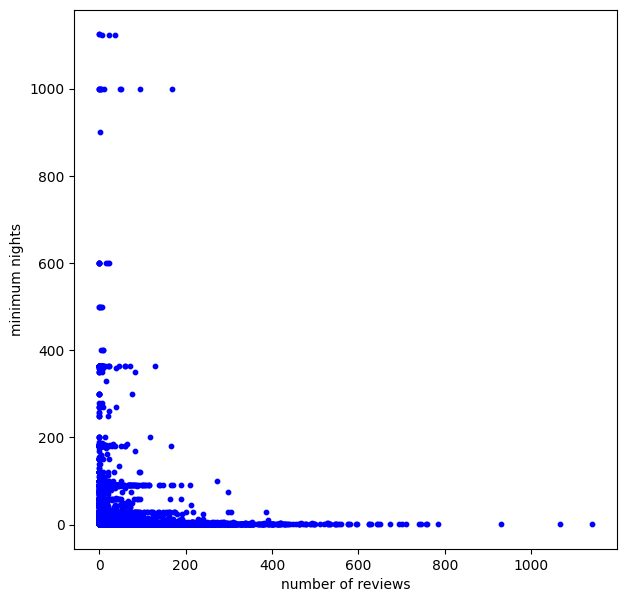

In [57]:
plt.figure(figsize=(7, 7))
plt.scatter(data['number_of_reviews'], data['minimum_nights'], marker = 'o', color = 'blue', s = 10)
plt.xlabel('number of reviews')
plt.ylabel('minimum nights')
pass

В левом нижнем углу, где наименьшие значения по минимальному количеству ночей и отзывам скопилось много точек, так как это очевидно наиболее распространенные услуги. Также заметно, что скопление точек расползается вдоль оси отзывов по той же причине и на треть меньше вдоль оси минимума ночей аренды. Выбросами будут являться значения минимума ночей более 400 и отзывы более 800, так как они сильно отличаются от основной массы. Скорее всего, это не ошибки в данных, но есть и такая возможность, но выбросы в любом случае мешают построить решающее правило, поэтому их рекомендуется выбрасывать. 

Для обнаружения выбросов найдем квантили для признаков "number_of_reviews" и "minimum_nights" 

In [58]:
data['number_of_reviews'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      0.0
0.010      0.0
0.050      0.0
0.100      0.0
0.500      4.0
0.900     46.0
0.950     80.0
0.990    199.0
0.995    255.0
Name: number_of_reviews, dtype: float64

99% всех значений признака 'number_of_reviews' находится в диапазоне от 0 до 255

In [59]:
data['minimum_nights'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     1.0
0.010     1.0
0.050     1.0
0.100     1.0
0.500     2.0
0.900     7.0
0.950    15.0
0.990    90.0
0.995    91.0
Name: minimum_nights, dtype: float64

99% всех значений признака 'minimum_nights' находится в диапазоне от 1 до 91

Удалим все строки, в которых 'number_of_reviews' или 'minimum_nights' выходят за пределы квантилей 0.005 и 0.995

In [60]:
rows_to_drop = data[
    (data['number_of_reviews'] < data['number_of_reviews'].quantile(0.005)) | (data['number_of_reviews'] > data['number_of_reviews'].quantile(0.995)) | 
    (data['minimum_nights']  < data['minimum_nights' ].quantile(0.005)) | (data['minimum_nights']  > data['minimum_nights' ].quantile(0.995))].index
data.drop(rows_to_drop, inplace=True)
print(data.index)
data.reset_index(inplace=True)
print(data.index)
print(data.shape)
rows_to_drop

Int64Index([    0,     1,     2,     4,     5,     7,     8,     9,    10,
               11,
            ...
            69340, 69341, 69342, 69343, 69345, 69346, 69347, 69348, 69349,
            69350],
           dtype='int64', length=68683)
RangeIndex(start=0, stop=68683, step=1)
(68683, 17)


Int64Index([    3,     6,    26,    31,    54,    59,    75,    91,   101,
              114,
            ...
            68580, 68713, 68770, 68837, 68862, 68898, 68900, 68920, 69138,
            69344],
           dtype='int64', length=668)

#### Широта и долгота Лондона

latitude and longitude coordinates for London (United Kingdom): 51.50853, -0.12574

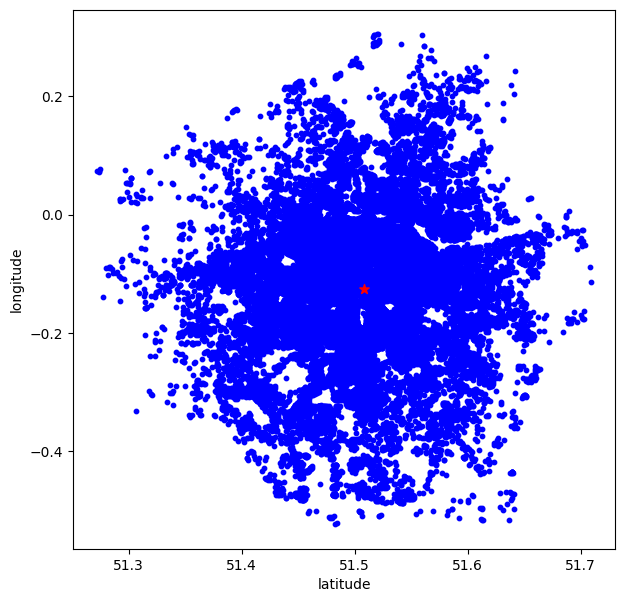

In [61]:
plt.figure(figsize=(7, 7))
plt.scatter(data['latitude'], data['longitude'], marker = 'o', color = 'blue', s = 10)
plt.scatter(51.50853, -0.12574, marker = '*', color = 'red', s = 50)
plt.xlabel('latitude')
plt.ylabel('longitude')
pass

#### Дата (представлена типом данных строка)

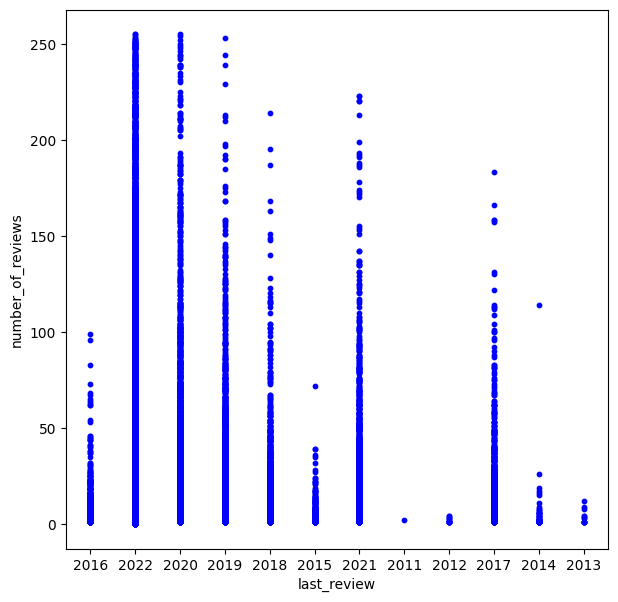

In [62]:
dataYLRNA = np.empty(0, dtype='str') # data Year Last Review np.array 
for i in range(0, len(data['last_review'])):
  dataYLRNA = np.append(dataYLRNA, data['last_review'][i][0:4])

dataYLRNA = pd.DataFrame({'year': dataYLRNA})

# last_review number_of_reviews
plt.figure(figsize=(7, 7))
plt.scatter(dataYLRNA['year'], data['number_of_reviews'], marker = 'o', color = 'blue', s = 10)
plt.xlabel('last_review')
plt.ylabel('number_of_reviews')
pass

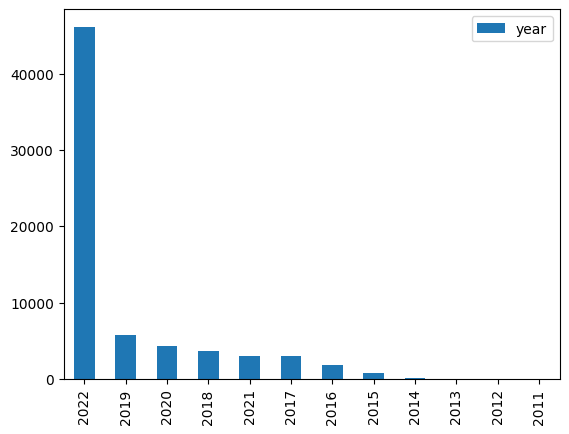

In [63]:
dataYLRNA.apply(pd.value_counts).plot(kind='bar')
pass

Данных за 2011-2014 года сравнительно мало, поэтому от них можно избавиться, датасет собран в основном из актуальной инормации за 22 год. Для этого добавим в наш датасет идентификационный столбец с годом, чтобы определить строки (экземпляры), которые требуется удалить. 

In [64]:
data.insert(len(data.columns)-1, 'year', dataYLRNA)
data.head()

,index,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,year,room_type
0,0,106332,"Lovely large room, Bethnal Green",264345,Susie,Tower Hamlets,51.52874,-0.05396,55,3,65,2016-06-10,0.47,1,74,0,2016,Private room
1,1,13913,Holiday London DB Room Let-on going,54730,Alina,Islington,51.56861,-0.11270,50,1,30,2022-07-15,0.20,2,343,9,2022,Private room
2,2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,1481412,Luca,Tower Hamlets,51.52851,-0.07426,90,5,42,2022-01-04,0.34,1,222,1,2022,Entire home/apt
3,4,284603,Notting Hill church stay in Heaven!,1481851,Tania,Kensington and Chelsea,51.51464,-0.20004,297,14,6,2022-07-04,0.05,1,180,2,2022,Entire home/apt
4,5,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,Kensington and Chelsea,51.48780,-0.16813,75,3,89,2020-03-16,0.57,1,70,0,2020,Entire home/apt


In [65]:
print(data.loc[data['year'] == '2011', 'year'])
#data.loc[data['year'] == '2012', 'year']
#data.loc[data['year'] == '2013', 'year']
#data.loc[data['year'] == '2014', 'year']
print(data.loc[data['year'] == '2011', 'year'].index)

46    2011
Name: year, dtype: object
Int64Index([46], dtype='int64')


In [66]:
data.drop(labels=data.loc[data['year'] == '2011', 'year'].index, axis = 0, inplace=True)
data.drop(labels=data.loc[data['year'] == '2012', 'year'].index, axis = 0, inplace=True)
data.drop(labels=data.loc[data['year'] == '2013', 'year'].index, axis = 0, inplace=True)
data.drop(labels=data.loc[data['year'] == '2014', 'year'].index, axis = 0, inplace=True)
data.drop(columns='year', axis=1, inplace=True)
print(data.index)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            68673, 68674, 68675, 68676, 68677, 68678, 68679, 68680, 68681,
            68682],
           dtype='int64', length=68586)


In [67]:
data.reset_index(inplace=True)

In [68]:
print(data.index)

RangeIndex(start=0, stop=68586, step=1)


In [69]:
# plt.figure(figsize=(7, 7))
# plt.scatter(data['year'], data['number_of_reviews'], marker = 'o', color = 'blue', s = 10)
# plt.xlabel('last_review')
# plt.ylabel('number_of_reviews')
# pass

In [70]:
data.head()

,level_0,index,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,room_type
0,0,0,106332,"Lovely large room, Bethnal Green",264345,Susie,Tower Hamlets,51.52874,-0.05396,55,3,65,2016-06-10,0.47,1,74,0,Private room
1,1,1,13913,Holiday London DB Room Let-on going,54730,Alina,Islington,51.56861,-0.11270,50,1,30,2022-07-15,0.20,2,343,9,Private room
2,2,2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,1481412,Luca,Tower Hamlets,51.52851,-0.07426,90,5,42,2022-01-04,0.34,1,222,1,Entire home/apt
3,3,4,284603,Notting Hill church stay in Heaven!,1481851,Tania,Kensington and Chelsea,51.51464,-0.20004,297,14,6,2022-07-04,0.05,1,180,2,Entire home/apt
4,4,5,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,Kensington and Chelsea,51.48780,-0.16813,75,3,89,2020-03-16,0.57,1,70,0,Entire home/apt


In [71]:
data.drop(['level_0', 'index'], axis = 1, inplace=True)
print(data.index)

RangeIndex(start=0, stop=68586, step=1)


### Обработка текстовых признаков

Текстовыми признаками являются 'name' и 'host_name'

In [72]:
print(data['host_name'].max())
print(data['host_name'].min())
data['host_name'].describe(include = object)

현석
'Cassie


count     68586
unique    12952
top        Alex
freq        521
Name: host_name, dtype: object

In [73]:
pd.set_option('display.max_rows', 100)
data['host_name'].head(100)

0                 Susie
1                 Alina
2                  Luca
3                 Tania
4              Philippa
5                   Liz
6                  Nora
7                   Joe
8                  Olga
9              Ragnhild
10                  Joe
11                 Andy
12    Veneranda And Leo
13             Yevgeniy
14    Veneranda And Leo
15                Grace
16              Anthony
17                 Cryn
18              Chi-Chi
19               Portia
20                  Liz
21                Neema
22                Geert
23                Clare
24                 Matt
25               Yasmin
26               Oliver
27               Milena
28          Elisa & Dom
29                Tania
30                 Paul
31                 Nina
32                 Alec
33                 Gill
34                Jamie
35             Carolina
36                 Paul
37               Sylvia
38                Grace
39                 Matt
40              Matthew
41              

In [74]:
data['host_name'][5000:5100]

5000                  Alex
5001                  Sian
5002                 Bethe
5003               Claudia
5004                Victor
5005                Rachel
5006               Massimo
5007                   Lin
5008                 Jiles
5009              Manuella
5010                 Wenxi
5011                 Steve
5012                 Jiles
5013                  Jake
5014        Andrea & Sarah
5015                 Lynne
5016              Veronica
5017                   Sam
5018                   Sam
5019                 Peter
5020                 Angie
5021               Tamanna
5022                 Susan
5023                Madhoo
5024               Siobhan
5025               Allison
5026                Simone
5027               Maxence
5028             Christina
5029                  Emma
5030                 Linda
5031                Gideon
5032               Vanessa
5033                    Jo
5034                Patrik
5035                 Peter
5036                  Lucy
5

In [75]:
for i in range(0, data.size):
  if data['host_name'][i].isdigit():
    print('i: ', i)
    print('host_name: ', data['host_name'][i])
    break

i:  24293
host_name:  39


In [76]:
data.loc[data['host_name'] == '39']

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,room_type
24293,23621965,Double Studio,175808255,39,Westminster,51.51282,-0.18590,185,1,93,2022-07-21,2.18,4,324,32,Private room
24299,23622035,Triple Studio for three guests,175808255,39,Westminster,51.51248,-0.18457,215,1,39,2022-07-11,1.05,4,270,10,Private room
24304,23622093,Single Studio for one person,175808255,39,Westminster,51.51113,-0.18440,183,1,14,2022-03-22,0.32,4,320,8,Private room
41821,42191684,Family studio with one double bed and two sing...,175808255,39,Westminster,51.51271,-0.18501,245,1,5,2022-06-28,0.27,4,250,1,Private room


In [77]:
data['host_name'][24292:24295]

24292      Tommy
24293         39
24294    Matthew
Name: host_name, dtype: object

In [78]:
# в настоящий момент удалим
data.drop(['name'], axis=1, inplace = True)
data.drop(['host_name'], axis = 1, inplace = True)

### 4. Обработка категориальных признаков

Категориальными признаками нашего набора данных являются: 'host_name', 'neighbourhood', 'last_review', 'room_type'. Признак 'last_review' представляет из себя дату, записанную в формате: 'yyyy-mm-dd': его можно обработать сначала как категориальный признак, избавившись от '-', тогда мы получим число вида yyyymmdd, а дальше его нормализовать. Признак 'room_type' будем обработан отличным образом, так как является целевым.  

Разделим признаки на числовые и категориальные



In [79]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
categorical_columns.remove('room_type')
# numerical_columns.remove('id')
# numerical_columns.remove('host_id')
print(categorical_columns)
print(numerical_columns)

['neighbourhood', 'last_review']
['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']


Категориальные признаки следует разделить на номинальные и порядковые

In [80]:
nominal_categorical_columns = categorical_columns[0]
ordinal_categorical_columns = categorical_columns[1]
print(nominal_categorical_columns)
print(ordinal_categorical_columns)

neighbourhood
last_review


#### 1-й способ (get_dummies from Pandas) (**Не применен, т.к. задача решена с помощью инструментов scikit-learn**)

Выделим среди категориальных признаков бинарные и небинарные, для этого выясним уникальные значения каждого категориального признака

In [81]:
# for c in categorical_columns:
#     print(c, data[c].unique())

In [82]:
# binary_columns    = [c for c in categorical_columns if len(data[c].unique()) == 2]
# nonbinary_columns = [c for c in categorical_columns if len(data[c].unique()) > 2]
# print(binary_columns, nonbinary_columns)

In [83]:
# data.count()

Пропущенных значений нет

Применим метод векторизации для категориальных признаков



In [84]:
# отсутствует
# data_binary = pd.get_dummies(data[binary_columns], drop_first=True)
# print(data_binary.columns)

In [85]:
# data_nonbinary = pd.get_dummies(data[nonbinary_columns])
# data_nonbinary.columns

#### 2-й способ (OrdinalEncoder from Scikit-learn)

Данный метод будет применен для порядковых признаков: 'last_review' - дата последнего отзыва

In [86]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(data[[ordinal_categorical_columns]]) # Если бы ordinal_categorical_columns был list, то одну пару квадратных скобок нужно было бы убрать

OrdinalEncoder()

In [87]:
dummies_ordinal = pd.DataFrame(enc.transform(data[[ordinal_categorical_columns]]),
                       columns = enc.get_feature_names_out(), index=data.index)
dummies_ordinal.head()

,last_review
0,407.0
1,2581.0
2,2389.0
3,2570.0
4,1774.0


In [88]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# catFeaturesEncoded = pd.DataFrame()

# for i in range(0, len(categorical_columns)):
#   value = ordinal_encoder.fit_transform(pd.DataFrame(data[categorical_columns[i]]))
#   valueFloat = np.zeros(len(value))
#   for j in range(0, len(value)):
#     valueFloat[j] = value[j][0]
#   catFeaturesEncoded.insert(loc = len(catFeaturesEncoded.columns),column = categorical_columns[i], value = valueFloat)
# catFeaturesEncoded.describe()


In [89]:
# value = ordinal_encoder.fit_transform(pd.DataFrame(data['room_type']))
# valueList = np.zeros(len(value))
# for j in range(0, len(value)):
#   valueList[j] = value[j]
# catFeaturesEncoded.insert(loc = len(catFeaturesEncoded.columns),column = 'room_type', value = valueList)
# catFeaturesEncoded.describe()

#### 3-й способ (OneHotEncoding from Scikit-learn)

Таким методом необходимо закодировать признаки, которые не являются бинарными, а они неупорядоченные и им могут соответствовать одинаковые данные.  
Данный метод будем применять для номинальных признаков: 'host_name' - имя хозяина, 'neighbourhood' - район города и 'room_type' - тип жилого помещения.

In [90]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
enc.fit(data[[nominal_categorical_columns]]) # Если бы nominal_categorical_columns был list, то одну пару квадратных скобок нужно было бы убрать

OneHotEncoder(sparse=False)

In [91]:
dummies_nominal = pd.DataFrame(enc.transform(data[[nominal_categorical_columns]]),
                       columns = enc.get_feature_names_out(), index=data.index)
dummies_nominal.head()

,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
data.head()

,id,host_id,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,room_type
0,106332,264345,Tower Hamlets,51.52874,-0.05396,55,3,65,2016-06-10,0.47,1,74,0,Private room
1,13913,54730,Islington,51.56861,-0.11270,50,1,30,2022-07-15,0.20,2,343,9,Private room
2,284532,1481412,Tower Hamlets,51.52851,-0.07426,90,5,42,2022-01-04,0.34,1,222,1,Entire home/apt
3,284603,1481851,Kensington and Chelsea,51.51464,-0.20004,297,14,6,2022-07-04,0.05,1,180,2,Entire home/apt
4,15400,60302,Kensington and Chelsea,51.48780,-0.16813,75,3,89,2020-03-16,0.57,1,70,0,Entire home/apt


In [93]:
data = pd.concat((dummies_nominal, dummies_ordinal, data), axis = 1)
data.describe()

,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,last_review,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,6.858600e+04,6.858600e+04,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000,68586.000000
mean,0.006270,0.023183,0.005978,0.029846,0.008646,0.068017,0.006036,0.015440,0.022395,0.008865,0.021739,0.074680,0.043114,0.027498,0.006444,0.004782,0.010177,0.015572,0.054603,0.066209,0.008836,0.053641,0.029277,0.016213,0.024320,0.009667,0.015980,0.057184,0.004141,0.080366,0.019144,0.050083,0.111655,2208.948517,1.386222e+17,1.246588e+08,51.509515,-0.128401,176.819584,4.715729,15.855072,0.754571,12.067521,107.970417,4.483772
std,0.078932,0.150484,0.077086,0.170163,0.092582,0.251777,0.077459,0.123298,0.147966,0.093735,0.145832,0.262876,0.203115,0.163532,0.080019,0.068989,0.100367,0.123812,0.227205,0.248649,0.093582,0.225309,0.168583,0.126296,0.154041,0.097844,0.125399,0.232195,0.064216,0.271861,0.137032,0.218118,0.314944,661.718216,2.660299e+17,1.378653e+08,0.049257,0.100961,400.520887,9.570489,31.134401,1.043046,37.331048,132.667577,9.990584
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.391300e+04,4.775000e+03,51.272480,-0.523600,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1761.000000,1.833477e+07,1.901715e+07,51.483000,-0.189510,55.000000,1.000000,1.000000,0.190000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2603.000000,3.418920e+07,6.058304e+07,51.513629,-0.126150,100.000000,2.000000,4.000000,0.430000,1.000000,31.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [94]:
data.drop(categorical_columns, axis = 1, inplace = True)
data.shape

(68586, 45)

### 5. Масштабирование данных (нормализация и стандартизация)

#### 1-й способ (Стандартизация с Pandas mean и std)

Нормализуем количественные признаки для улучшения работы некоторых алгоритмов машинного обучения. Для бинарных признаков такой подход избыточный.



In [95]:
# data_numerical = data[numerical_columns]
# data_numerical.describe()

In [96]:
# data_numerical = (data_numerical - data_numerical.mean(axis=0))/data_numerical.std(axis=0)
# data_numerical.describe()

#### 2-й способ (Нормализация с Scikit-learn)

#### 3-й способ (Стандартизация с Scikit-learn)

In [97]:
from sklearn.preprocessing import StandardScaler

room_type = data['room_type']
data.drop(['room_type'], axis = 1, inplace = True) 

scaler = StandardScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns = data.columns, index = data.index)

In [98]:
data.head()

,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,-0.521081,-0.902296,0.390299,0.737324,-0.304155,-0.179274,1.578488,-0.272829,-0.296472,-0.256059,-0.448803
1,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,4.161012,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-0.521081,-0.903817,1.199725,0.155513,-0.316639,-0.388251,0.454322,-0.531688,-0.269684,1.771581,0.452052
2,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,-0.521081,-0.893468,0.385630,0.536255,-0.216768,0.029703,0.839750,-0.397465,-0.296472,0.859520,-0.348708
3,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,3.755492,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-0.521081,-0.893465,0.104046,-0.709577,0.300062,0.970101,-0.316536,-0.675499,-0.296472,0.542937,-0.248613
4,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,3.755492,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-0.521081,-0.903776,-0.440850,-0.393513,-0.254220,-0.179274,2.349345,-0.176956,-0.296472,-0.286209,-0.448803


### 2.2 Визуализация и описательная статистика 2

Получим сводную информацию о данных с помощью функции describe:  
- count - количество элементов в столбце
- mean - среднее значение элементов
- std - стандартное отклонение значения
- min - минимальное значение
- 25% - нижний квартиль (25% значений меньше нижнего квартиля и 75% значений больше нижнего квартиля)
- 50% - медиана (50% значений меньше (ниже, левее) медианы и 50% больше (выше, правее) медианы)
- 75% - верхний квартиль (75% значений меньше верхнего квартиля и 25% значений больше верхнего квартиля)
- max - максимальное значениe
* freq - количество самого частого объекта (object)

На матрице диаграмм рассеивания наблюдается зависимость между числом отзывов ('number_of_reviews') и количеством отзывов в месяц ('reviews_per_month'), а также с этими двумя признаками коррелирует признак 'number_of_reviews_ltr'.

In [99]:
# data.corr() > 0.5

### 6. Разбиение данных на обучающую и тестовую выборки

In [100]:
data.insert(loc = len(data.columns), column = 'room_type', value = room_type)

In [101]:
data.drop(['id','host_id', 'number_of_reviews_ltm'], axis = 1, inplace = True)

In [102]:
print(data.shape)
data.head()

(68586, 42)


,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type
0,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,0.390299,0.737324,-0.304155,-0.179274,1.578488,-0.272829,-0.296472,-0.256059,Private room
1,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,4.161012,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,1.199725,0.155513,-0.316639,-0.388251,0.454322,-0.531688,-0.269684,1.771581,Private room
2,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,0.385630,0.536255,-0.216768,0.029703,0.839750,-0.397465,-0.296472,0.859520,Entire home/apt
3,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,3.755492,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,0.104046,-0.709577,0.300062,0.970101,-0.316536,-0.675499,-0.296472,0.542937,Entire home/apt
4,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,3.755492,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-0.440850,-0.393513,-0.254220,-0.179274,2.349345,-0.176956,-0.296472,-0.286209,Entire home/apt


In [103]:
data.describe()

,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,6.858600e+04,68586.000000
mean,2.362053e-17,-4.019633e-17,2.652129e-17,-6.298807e-17,2.900766e-17,7.127598e-17,-4.143952e-17,-2.735008e-17,2.610690e-17,7.459114e-18,-4.454748e-17,2.486371e-18,3.646678e-17,5.801533e-18,-6.630323e-18,-2.320613e-17,2.983645e-17,-8.287904e-18,-2.154855e-17,1.450383e-17,-2.983645e-17,-1.375792e-16,1.035988e-17,-3.107964e-17,-4.558347e-17,8.080706e-17,-3.480920e-17,-3.522359e-17,2.735008e-17,-9.406771e-17,-1.781899e-17,2.610690e-17,-6.754642e-17,2.897534e-14,-6.464565e-17,-4.351150e-18,-3.605238e-17,3.315162e-18,1.611997e-16,1.212106e-17,0.000000
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007
min,-7.942956e-02,-1.540544e-01,-7.754899e-02,-1.753964e-01,-9.338890e-02,-2.701494e-01,-7.792865e-02,-1.252303e-01,-1.513548e-01,-9.457309e-02,-1.490712e-01,-2.840901e-01,-2.122647e-01,-1.681543e-01,-8.053735e-02,-6.932025e-02,-1.013984e-01,-1.257696e-01,-2.403262e-01,-2.662767e-01,-9.441603e-02,-2.380779e-01,-1.736667e-01,-1.283761e-01,-1.578798e-01,-9.879804e-02,-1.274341e-01,-2.462762e-01,-6.448259e-02,-2.956170e-01,-1.397050e-01,-2.296164e-01,-3.545269e-01,-4.812197e+00,-3.914392e+00,-4.414773e-01,-3.882514e-01,-5.092498e-01,-7.138486e-01,-2.964718e-01,-0.813848
25%,-7.942956e-02,-1.540544e-01,-7.754899e-02,-1.753964e-01,-9.338890e-02,-2.701494e-01,-7.792865e-02,-1.252303e-01,-1.513548e-01,-9.457309e-02,-1.490712e-01,-2.840901e-01,-2.122647e-01,-1.681543e-01,-8.053735e-02,-6.932025e-02,-1.013984e-01,-1.257696e-01,-2.403262e-01,-2.662767e-01,-9.441603e-02,-2.380779e-01,-1.736667e-01,-1.283761e-01,-1.578798e-01,-9.879804e-02,-1.274341e-01,-2.462762e-01,-6.448259e-02,-2.956170e-01,-1.397050e-01,-2.296164e-01,-3.545269e-01,-5.382976e-01,-6.052792e-01,-3.041551e-01,-3.882514e-01,-4.771308e-01,-5.412758e-01,-2.964718e-01,-0.813848
50%,-7.942956e-02,-1.540544e-01,-7.754899e-02,-1.753964e-01,-9.338890e-02,-2.701494e-01,-7.792865e-02,-1.252303e-01,-1.513548e-01,-9.457309e-02,-1.490712e-01,-2.840901e-01,-2.122647e-01,-1.681543e-01,-8.053735e-02,-6.932025e-02,-1.013984e-01,-1.257696e-01,-2.403262e-01,-2.

In [104]:
X = data.drop(['room_type'], axis = 1)
Y = data['room_type']

In [105]:
X.head()

,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,0.390299,0.737324,-0.304155,-0.179274,1.578488,-0.272829,-0.296472,-0.256059
1,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,4.161012,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,1.199725,0.155513,-0.316639,-0.388251,0.454322,-0.531688,-0.269684,1.771581
2,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,0.385630,0.536255,-0.216768,0.029703,0.839750,-0.397465,-0.296472,0.859520
3,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,3.755492,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,0.104046,-0.709577,0.300062,0.970101,-0.316536,-0.675499,-0.296472,0.542937
4,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,3.755492,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-0.440850,-0.393513,-0.254220,-0.179274,2.349345,-0.176956,-0.296472,-0.286209


In [106]:
Y.head()

0       Private room
1       Private room
2    Entire home/apt
3    Entire home/apt
4    Entire home/apt
Name: room_type, dtype: object

#### Векторизуем категориальный признак 'room_type' 

In [107]:
enc = OneHotEncoder(sparse=False)
Y = enc.fit_transform(pd.DataFrame(Y))
print(Y[:10])
print(enc.categories_)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[array(['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'],
      dtype=object)]


In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 173)

N_train, _ = X_train.shape
N_test, _ = X_test.shape

N_train, N_test

(51439, 17147)

In [109]:
X_train.head()

,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,neighbourhood_Camden,neighbourhood_City of London,neighbourhood_Croydon,neighbourhood_Ealing,neighbourhood_Enfield,neighbourhood_Greenwich,neighbourhood_Hackney,neighbourhood_Hammersmith and Fulham,neighbourhood_Haringey,neighbourhood_Harrow,neighbourhood_Havering,neighbourhood_Hillingdon,neighbourhood_Hounslow,neighbourhood_Islington,neighbourhood_Kensington and Chelsea,neighbourhood_Kingston upon Thames,neighbourhood_Lambeth,neighbourhood_Lewisham,neighbourhood_Merton,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
43413,-0.07943,-0.154054,-0.077549,-0.175396,10.707911,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-2.107208,0.628965,-0.406523,-0.179274,-0.509250,-0.311179,-0.296472,-0.813848
5566,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,3.382755,-0.139705,-0.229616,-0.354527,0.403292,0.775953,0.007941,-0.283763,-0.155940,-0.598800,-0.269684,-0.813848
67826,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,3.701655,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,0.373342,0.094246,-0.314142,-0.388251,-0.509250,-0.311179,0.051766,1.040424
54448,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,-0.149071,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,2.820660,0.273362,-0.680457,-0.206781,-0.283763,0.357964,3.389549,-0.269684,1.055500
9631,-0.07943,-0.154054,-0.077549,-0.175396,-0.093389,-0.270149,-0.077929,-0.12523,-0.151355,-0.094573,6.708204,-0.28409,-0.212265,-0.168154,-0.080537,-0.06932,-0.101398,-0.12577,-0.240326,-0.266277,-0.094416,-0.238078,-0.173667,-0.128376,-0.15788,-0.098798,-0.127434,-0.246276,-0.064483,-0.295617,-0.139705,-0.229616,-0.354527,-0.836935,1.827452,-0.354090,-0.388251,0.871869,-0.205718,-0.296472,1.620827


### 7.1 Применение классификатора ближайших соседей (kNN) (n_neighbors = 7)

In [110]:
# Импорт модуля
from sklearn.neighbors import KNeighborsClassifier
# Создание и обучение модели на тренировочных данных (обучающей выборке) 
model = KNeighborsClassifier(n_neighbors = 7) # default n_neighbors = 5
model.fit(X_train, y_train)
model

KNeighborsClassifier(n_neighbors=7)

In [111]:
# Проверка работы модели на тренировочных и тестовых данных
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)
# Вычислим оценки вероятности для создания графика roc_curve для метода LogReg
y_train_pred_prob = model.predict_proba(X_train)
y_test_pred_prob = model.predict_proba(X_test)
# Средняя сумма квадратов отклонений (MSE - Mean Squared Error), где RSS - Residual Sum of Squares - остаточная сумма квадратов
RSS_train = ((y_train_predict - y_train)**2).sum()
print(RSS_train/N_train)

0.3348626528509497


### 8.1 Вычисление ошибки на обучающей и тестовой выборках

Важно отметить, что для задачи классификации с несбалансированными классами (*на данный момент проблема несбалансированных классов не решена*) основными метриками качества алгоритмов машинного обучения будут являться F1_score (как среднее гармоническое между precision, recall) и график PC-кривой.  
Метрики MSE (среднеквадратичная ошибка), RMSE (корень из серднеквадратичной ошибки) и R2 (коэффициент детерминации) - метрики анализа моделей для задачи регрессии

In [193]:
# Загрузка необходимых метрик для анализа 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score, max_error, plot_confusion_matrix, confusion_matrix

In [173]:
# Вычисление различных метрик для тренировочных и тестовых данных
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)
precision_train = precision_score(y_train, y_train_predict)
precision_test = precision_score(y_test, y_test_predict)
recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)
f1_train = f1_score(y_train, y_train_predict, average = 'weighted')
f1_test = f1_score(y_test, y_test_predict, average = 'weighted')
print('accuracy:', accuracy_train, accuracy_test, '\n', 'f1:', f1_train, f1_test)
MSE_train = mean_squared_error(y_train, y_train_predict) 
MSE_test = mean_squared_error(y_test, y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test = r2_score(y_test, y_test_predict)
print('MSE:', MSE_train, MSE_test, '\n', 'R2:', R2_train, R2_test)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [113]:
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)
print('RMSE:', RMSE_train, RMSE_test)

RMSE: 0.2893365915551253 0.34041199879045225


Создадим таблицу для хранения результатов разных моделей машинного обучения

In [114]:
accuracy_table = pd.DataFrame(columns=('train', 'test'))
accuracy_table.loc['KNN, n=7', :] = (accuracy_train, accuracy_test)
precision_table = pd.DataFrame(columns=('train', 'test'))
precision_table.loc['KNN, n=7', :] = (accuracy_train, accuracy_test)
recall_table = pd.DataFrame(columns=('train', 'test'))
recall_table.loc['KNN, n=7', :] = (accuracy_train, accuracy_test)
f1_table = pd.DataFrame(columns =('train', 'test'))
f1_table.loc['KNN, n=7', :] = (f1_train, f1_test)
RMSE_table = pd.DataFrame(columns=('train', 'test'))
RMSE_table.loc['KNN, n=7', :] = (RMSE_train, RMSE_test)
R2_table = pd.DataFrame(columns=('train', 'test'))
R2_table.loc['KNN, n=7', :] = (R2_train, R2_test)

In [115]:
RMSE_table

,train,test
"KNN, n=7",0.289337,0.340412


In [116]:
R2_table

,train,test
"KNN, n=7",0.229653,0.066108


In [117]:
accuracy_table

,train,test
"KNN, n=7",0.828787,0.763807


In [ ]:
precision_table

In [ ]:
recall_table

In [118]:
f1_table

,train,test
"KNN, n=7",0.829282,0.764681


### 7.2 Применение классификатора на основе метода ближайших соседей (kNN) (n_neighbors = 7) и GridSearchCV

In [121]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors':[3, 5, 7, 9, 15, 21]}
model = KNeighborsClassifier()
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 15, 21]})

In [122]:
clf.best_params_, clf.best_score_

({'n_neighbors': 7}, 0.7579074477730201)

In [123]:
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

### 8.2 Вычисление ошибки на обучающей и тестовой выборках

In [124]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)
precision_train = precision_score(y_train, y_train_predict)
precision_test = precision_score(y_test, y_test_predict)
recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)
f1_train = f1_score(y_train, y_train_predict, average = 'weighted')
f1_test = f1_score(y_test, y_test_predict, average = 'weighted')
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test = mean_squared_error(y_test, y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test = r2_score(y_test, y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

accuracy_table.loc['KNN, GridSearchCV', :] = (accuracy_train, accuracy_test)
precision_table.loc['KNN, GridSearchCV', :] = (accuracy_train, accuracy_test)
recall_table.loc['KNN, GridSearchCV', :] = (accuracy_train, accuracy_test)
f1_table.loc['KNN, GridSearchCV', :] = (f1_train, f1_test)
RMSE_table.loc['KNN, GridSearchCV', :] = (RMSE_train, RMSE_test)
R2_table.loc['KNN, GridSearchCV', :] = (R2_train, R2_test)

In [125]:
RMSE_table

,train,test
"KNN, n=7",0.289337,0.340412
"KNN, GridSearchCV",0.289337,0.340412


In [126]:
R2_table

,train,test
"KNN, n=7",0.229653,0.066108
"KNN, GridSearchCV",0.229653,0.066108


### 9.1 Random Forest (Случайный лес)

In [127]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(X_train, y_train)
model

RandomForestClassifier(max_depth=2, random_state=0)

In [128]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

### 9.1.1 Вычисление ошибки на обучающей и тестовой выборках

In [129]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)
precision_train = precision_score(y_train, y_train_predict)
precision_test = precision_score(y_test, y_test_predict)
recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)
f1_train = f1_score(y_train, y_train_predict, average = 'weighted')
f1_test = f1_score(y_test, y_test_predict, average = 'weighted')
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test = mean_squared_error(y_test, y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test = r2_score(y_test, y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

accuracy_table.loc['RandomForestClassifier, max_depth=2, random_state=0', :] = (accuracy_train, accuracy_test)
precision_table.loc['RandomForestClassifier, max_depth=2, random_state=0', :] = (accuracy_train, accuracy_test)
recall_table.loc['RandomForestClassifier, max_depth=2, random_state=0', :] = (accuracy_train, accuracy_test)
f1_table.loc['RandomForestClassifier, max_depth=2, random_state=0', :] = (f1_train, f1_test)
RMSE_table.loc['RandomForestClassifier, max_depth=2, random_state=0', :] = (RMSE_train, RMSE_test)
R2_table.loc['RandomForestClassifier, max_depth=2, random_state=0', :] = (R2_train, R2_test)

In [130]:
RMSE_table

,train,test
"KNN, n=7",0.289337,0.340412
"KNN, GridSearchCV",0.289337,0.340412
"Random Forests, max_depth=2, random_state=0",0.359804,0.363105


In [131]:
R2_table

,train,test
"KNN, n=7",0.229653,0.066108
"KNN, GridSearchCV",0.229653,0.066108
"Random Forests, max_depth=2, random_state=0",-0.03317,-0.042235


### 9.2 Random Forest (Случайный лес) и GridSearchCV (Поиск по сетке)

In [132]:
model = RandomForestClassifier()

parameters = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
}

clf = GridSearchCV(estimator=model, param_grid=parameters, cv= 5) # cv=None or 5 - is default

In [133]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [134]:
clf.best_params_, clf.best_score_

({'max_depth': 8, 'n_estimators': 200}, 0.8469644624623236)

In [135]:
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

### 9.2.1 Вычисление ошибки на обучающей и тестовой выборках

In [136]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)
precision_train = precision_score(y_train, y_train_predict)
precision_test = precision_score(y_test, y_test_predict)
recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)
f1_train = f1_score(y_train, y_train_predict, average = 'weighted')
f1_test = f1_score(y_test, y_test_predict, average = 'weighted')
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test = mean_squared_error(y_test, y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test = r2_score(y_test, y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

accuracy_table.loc['RandomForestClassifier, GridSearchCV', :] = (accuracy_train, accuracy_test)
precision_table.loc['RandomForestClassifier, GridSearchCV', :] = (accuracy_train, accuracy_test)
recall_table.loc['RandomForestClassifier, GridSearchCV', :] = (accuracy_train, accuracy_test)
f1_table.loc['RandomForestClassifier, GridSearchCV', :] = (f1_train, f1_test)
RMSE_table.loc['RandomForestClassifier, GridSearchCV', :] = (RMSE_train, RMSE_test)
R2_table.loc['RandomForestClassifier, GridSearchCV', :] = (R2_train, R2_test)

### 9.3 Decision Tree Classifier (Деревья решений)

In [137]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

### 9.3.1 Вычисление ошибки на обучающей и тестовой выборках

In [138]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)
precision_train = precision_score(y_train, y_train_predict)
precision_test = precision_score(y_test, y_test_predict)
recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)
f1_train = f1_score(y_train, y_train_predict, average = 'weighted')
f1_test = f1_score(y_test, y_test_predict, average = 'weighted')
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test = mean_squared_error(y_test, y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test = r2_score(y_test, y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

accuracy_table.loc['DecisionTreeClassifier', :] = (accuracy_train, accuracy_test)
precision_table.loc['DecisionTreeClassifier', :] = (accuracy_train, accuracy_test)
recall_table.loc['DecisionTreeClassifier', :] = (accuracy_train, accuracy_test)
f1_table.loc['DecisionTreeClassifier', :] = (f1_train, f1_test)
RMSE_table.loc['DecisionTreeClassifier', :] = (RMSE_train, RMSE_test)
R2_table.loc['DecisionTreeClassifier', :] = (R2_train, R2_test)

### 9.4 Gradient Boosting Classifier (Градиентный бустинг)

In [139]:
# from sklearn.ensemble import GradientBoostingClassifier

# model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# model.fit(X_train, y_train)
# y_train_predict = model.predict(X_train)
# y_test_predict = model.predict(X_test)

### 9.4.1 Вычисление ошибки на обучающей и тестовой выборках

In [140]:
# accuracy_train = accuracy_score(y_train, y_train_predict)
# accuracy_test = accuracy_score(y_test, y_test_predict)
# precision_train = precision_score(y_train, y_train_predict)
# precision_test = precision_score(y_test, y_test_predict)
# recall_train = recall_score(y_train, y_train_predict)
# recall_test = recall_score(y_test, y_test_predict)
# f1_train = f1_score(y_train, y_train_predict, average = 'weighted')
# f1_test = f1_score(y_test, y_test_predict, average = 'weighted')ct)
# MSE_train = mean_squared_error(y_train, y_train_predict)
# MSE_test = mean_squared_error(y_test, y_test_predict)
# R2_train = r2_score(y_train, y_train_predict)
# R2_test = r2_score(y_test, y_test_predict)
# RMSE_train = (MSE_train)**(.5)
# RMSE_test = (MSE_test)**(.5)

# accuracy_table.loc['GradientBoostingClassifier', :] = (accuracy_train, accuracy_test)
# precision_table.loc['GradientBoostingClassifier', :] = (accuracy_train, accuracy_test)
# recall_table.loc['GradientBoostingClassifier', :] = (accuracy_train, accuracy_test)
# f1_table.loc['GradientBoostingClassifier', :] = (f1_train, f1_test)
# RMSE_table.loc['GradientBoostingClassifier', :] = (RMSE_train, RMSE_test)
# R2_table.loc['GradientBoostingClassifier', :] = (R2_train, R2_test)

In [141]:
RMSE_table

,train,test
"KNN, n=7",0.289337,0.340412
"KNN, GridSearchCV",0.289337,0.340412
"Random Forests, max_depth=2, random_state=0",0.359804,0.363105
"Random Forests, GridSearchCV",0.268876,0.271506
DecisionTreeClassifier,0.0,0.296703


In [142]:
R2_table

,train,test
"KNN, n=7",0.229653,0.066108
"KNN, GridSearchCV",0.229653,0.066108
"Random Forests, max_depth=2, random_state=0",-0.03317,-0.042235
"Random Forests, GridSearchCV",0.205636,0.199887
DecisionTreeClassifier,1.0,-0.034405


### 12. Выводы

In [151]:
print(accuracy_table)
print(f1_table)
print(RMSE_table)
print(R2_table)

                                                train      test
KNN, n=7                                     0.828787  0.763807
KNN, GridSearchCV                            0.828787  0.763807
Random Forests, max_depth=2, random_state=0  0.720815  0.714002
Random Forests, GridSearchCV                 0.852797  0.849711
DecisionTreeClassifier                            1.0  0.823934
LogReg, solver = lbfgs                       0.726219  0.723275
                                                train      test
KNN, n=7                                     0.829282  0.764681
KNN, GridSearchCV                            0.829282  0.764681
Random Forests, max_depth=2, random_state=0  0.699249  0.691626
Random Forests, GridSearchCV                 0.848885  0.846249
DecisionTreeClassifier                            1.0  0.824168
LogReg, solver = lbfgs                       0.713538  0.710989
                                                train      test
KNN, n=7                                

По результатам анализа данных и проведенных экспериментов с различными классификаторами можно сделать следующие выводы:
По первичному анализу набора данных: 
- пропущенные значения (14.61%); 
- представлены разнородные признаки (имена, идентификаторы, местоположение, стоимость);
- классы по целевому признаку несбалансированные (41224/244/27479/404);
- выбросы присутсвуют, но не составляют значительную часть набора данных;
- присутствуют текстовые признаки, но не был на данный момент подобран метод их обработки.  
  
По таблице видно, что наилучший результат дал классификатор KNN (ближайших соседей) с параметром n_neighbors = 7. (train: 0.229653, test:	0.066108)

### 13.1 Применение классификатора Logistic Regression (Логистическая Регрессия)
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [171]:
# Создадим новые таблицы для сравнения разных моделей
accuracy_table = pd.DataFrame(columns=('train', 'test'))
precision_table = pd.DataFrame(columns=('train','test'))
recall_table = pd.DataFrame(columns=('train', 'test'))
f1_table = pd.DataFrame(columns=('train', 'test'))

In [ ]:
from sklearn.linear_model import LogisticRegression
# Default
model = LogisticRegression(penalty='l2', # default = l2
                           solver = 'lbdgs', # default = 'lbdgs'
                           random_state=42) 
model.fit(X_train, y_train.argmax(axis = 1))
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

e:\Временное хранилище\Repository\ml_nngu_7sem\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 13.1.1 Вычисление ошибки на обучающей и тестовой выборках

In [ ]:
accuracy_train = accuracy_score(y_train.argmax(axis = 1), y_train_predict)
accuracy_test = accuracy_score(y_test.argmax(axis = 1), y_test_predict)
precision_train = precision_score(y_train, y_train_predict)
precision_test = precision_score(y_test, y_test_predict)
recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)
f1_train = f1_score(y_train.argmax(axis = 1), y_train_predict, average = 'weighted')
f1_test = f1_score(y_test.argmax(axis = 1), y_test_predict, average = 'weighted')

accuracy_table.loc['LogisticRegression, default', :] = (accuracy_train, accuracy_test)
precision_table.loc['LogisticRegression, default', :] = (precision_train, precision_test)
recall_table.loc['LogisticRegression, default', :] = (recall_train, recall_test)
f1_table.loc['LogisticRegression, default', :] = (f1_train, f1_test)

### 13.2. Полносвязная нейронная сеть с 1 скрытым слоем (vanilla)
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Многослойный персептрон


In [168]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), # Количество нейронов в скрытом слое; default = (100,); кортеж (Y1,Y2, ...,Yk) - количество скрытых слоев, где Yi - количество нейронов в скрытом слое
                          activation = 'relu', # Функция активации для скрытого слоя; default = 'relu'
                          solver = 'adam',  # Алгоритм для поиска оптимальных весов; default = 'adam'
                          alpha = 0.0001, # Регуляризация - метод борьбы с переобучением; default = 0.0001 
                          random_state = 42)
mlp_model.fit(X_train, y_train)    
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

e:\Временное хранилище\Repository\ml_nngu_7sem\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 13.2.1. Вычисление ошибки на обучающей и тестовой выборках

In [169]:
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.06237485176616964, 0.06750451974106257)

In [180]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
f1_test = f1_score(y_test, y_test_pred, average = 'weighted')

accuracy_table.loc['MLPClassifier, default', :] = (accuracy_train, accuracy_test)
precision_table.loc['MLPClassifier, default', :] = (precision_train, precision_test)
recall_table.loc['MLPClassifier, default', :] = (recall_train, recall_test)
f1_table.loc['MLPClassifier, default', :] = (f1_train, f1_test)

In [181]:
accuracy_table

,train,test
"MLPClassifier, default",0.869438,0.859276


In [182]:
precision_table

,train,test
"MLPClassifier, default",0.87741,0.866728


In [183]:
recall_table

,train,test
"MLPClassifier, default",0.872101,0.86155


In [184]:
f1_table

,train,test
"MLPClassifier, default",0.871775,0.861764


### 13.2.2. Choosing hyperparameters (Подбор гиперпараметров)

Let's try to find the optimal value for regularization parameter alpha (Подбор оптимального значения параметра регуляризации). С помощью цикла, написанного вручную и GridSearchCV.

In [185]:
# Диапазон изменений параметра alpha - регуляризации 
alpha_arr = np.logspace(-4, 5, 10)
print(alpha_arr,'\n','1.e-04: ', 1.e-04)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05] 
 1.e-04:  0.0001


In [186]:
# С помощью цикла, написанного вручную (~8мин)
train_err = [] # Ошибки на тренировочных данных при разном параметре
test_err = [] # Ошибки на тестовых данных при разном параметре
for alpha in alpha_arr:
  mlp_model = MLPClassifier(hidden_layer_sizes=(100,),
              alpha=alpha, 
              random_state=42)
  mlp_model.fit(X_train, y_train)
  y_train_pred = mlp_model.predict(X_train)
  y_test_pred = mlp_model.predict(X_test)
  train_err.append(np.mean(y_train != y_train_pred))
  test_err.append(np.mean(y_test != y_test_pred))

e:\Временное хранилище\Repository\ml_nngu_7sem\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\Временное хранилище\Repository\ml_nngu_7sem\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\Временное хранилище\Repository\ml_nngu_7sem\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Построим график зависимости ошибки от параметра регуляризации, причем, ось абцисс будет развернута, таким образом крайнее левое положение - недообучение модели, а крайнее правое положение - переобучение модели.

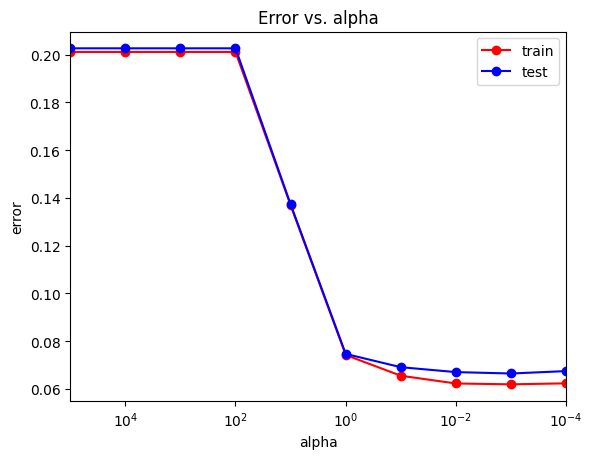

In [187]:
plt.semilogx(alpha_arr, train_err, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'b-o', label = 'test')
plt.xlim(np.max(alpha_arr), np.min(alpha_arr))
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
plt.show()

Минимальное значение ошибки:

In [188]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.06196660121697545 0.06649851285939232


Оптимальное значение alpha:

In [189]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.001]


Повторим обучение при новом значении alpha

In [192]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          activation = 'relu',
                          solver = 'adam',
                          alpha = alpha_opt,
                          random_state = 42)
mlp_model.fit(X_train, y_train)    
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

e:\Временное хранилище\Repository\ml_nngu_7sem\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.06196660121697545, 0.06649851285939232)

Построим матрицу рассогласования (confusion matrix)

In [197]:
print(confusion_matrix(y_test_pred.argmax(axis = 1), y_test.argmax(axis = 1)))

[[9280   31 1228   12]
 [   0   10    1    0]
 [ 917   14 5573   81]
 [   0    0    0    0]]


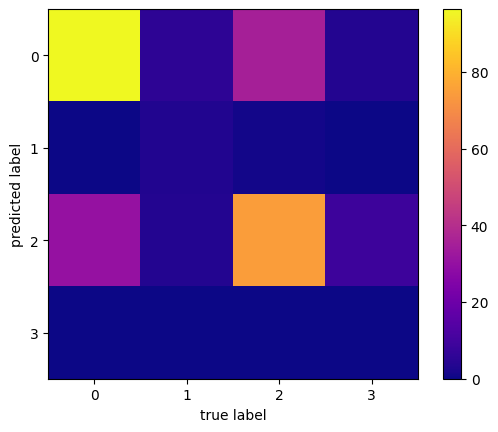

In [205]:
cm = confusion_matrix(y_test_pred.argmax(axis = 1), y_test.argmax(axis = 1))
cm = np.sqrt(cm)
plt.imshow(cm, interpolation = 'nearest')
plt.set_cmap('plasma')
plt.xticks(range(4))
plt.yticks(range(4))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

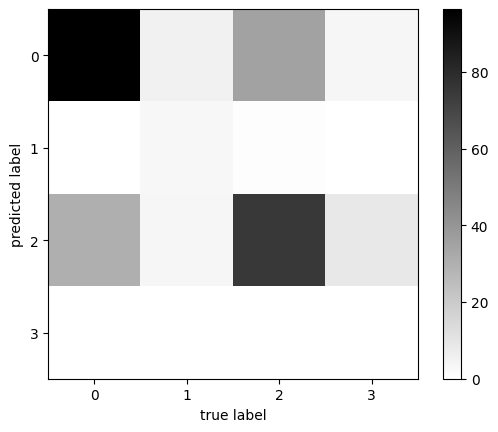

In [206]:
cm = confusion_matrix(y_test_pred.argmax(axis = 1), y_test.argmax(axis = 1))
cm = np.sqrt(cm)
plt.imshow(cm, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(4))
plt.yticks(range(4))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

Применим GridSearchCV

### 13.2.3. Вычисление ошибки на обучающей и тестовой выборках

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
f1_test = f1_score(y_test, y_test_pred, average = 'weighted')

accuracy_table.loc['MLPClassifier, GridSearchCV', :] = (accuracy_train, accuracy_test)
precision_table.loc['MLPClassifier, GridSearchCV', :] = (precision_train, precision_test)
recall_table.loc['MLPClassifier, GridSearchCV', :] = (recall_train, recall_test)
f1_table.loc['MLPClassifier, GridSearchCV', :] = (f1_train, f1_test)

### 13.3. Полносвязная нейронная сеть с 2 слоями

### 13.3.1. Вычисление ошибки на обучающей и тестовой выборках

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
f1_test = f1_score(y_test, y_test_pred, average = 'weighted')

accuracy_table.loc['MLPClassifier, n_layers-2, other - default', :] = (accuracy_train, accuracy_test)
precision_table.loc['MLPClassifier, n_layers-2, other - default', :] = (precision_train, precision_test)
recall_table.loc['MLPClassifier, n_layers-2, other - default', :] = (recall_train, recall_test)
f1_table.loc['MLPClassifier, n_layers-2, other - default', :] = (f1_train, f1_test)

### 13.3.2. Подбор гиперпараметров

### 13.3.3. Вычисление ошибки на обучающей и тестовой выборках

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
f1_test = f1_score(y_test, y_test_pred, average = 'weighted')

accuracy_table.loc['MLPClassifier, n_layers-2, GridSearchCV', :] = (accuracy_train, accuracy_test)
precision_table.loc['MLPClassifier, n_layers-2, GridSearchCV', :] = (precision_train, precision_test)
recall_table.loc['MLPClassifier, n_layers-2, GridSearchCV', :] = (recall_train, recall_test)
f1_table.loc['MLPClassifier, n_layers-2, GridSearchCV', :] = (f1_train, f1_test)

### 13.4. RandomForestClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 13.4.1. Вычисление ошибки на обучающей и тестовой выборке

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
f1_test = f1_score(y_test, y_test_pred, average = 'weighted')

accuracy_table.loc['RandomForestClassifier, default', :] = (accuracy_train, accuracy_test)
precision_table.loc['RandomForestClassifier, default', :] = (precision_train, precision_test)
recall_table.loc['RandomForestClassifier, default', :] = (recall_train, recall_test)
f1_table.loc['RandomForestClassifier, default', :] = (f1_train, f1_test)

### 13.4.2. Подбор гиперпараметров

### 13.4.3. Вычисление ошибки на обучающей и тестовой выборке

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
f1_test = f1_score(y_test, y_test_pred, average = 'weighted')

accuracy_table.loc['RandomForestClassifier, GridSearchCV', :] = (accuracy_train, accuracy_test)
precision_table.loc['RandomForestClassifier, GridSearchCV', :] = (precision_train, precision_test)
recall_table.loc['RandomForestClassifier, GridSearchCV', :] = (recall_train, recall_test)
f1_table.loc['RandomForestClassifier, GridSearchCV', :] = (f1_train, f1_test)

### 14. Вывод